# Risk assessment for river flooding

Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/FLOODS/main?labpath=Risk_assessment_FLOOD_RIVER.ipynb) to open this workflow on Binder.  
Click [![Flood](https://img.shields.io/badge/FLOOD-repository-blue)](https://github.com/CLIMAAX/FLOODS) to go to this workflow's GitHub repository.

In this workflow we will visualize risks to built infrastructure presented by river flooding. The damages will be calculated using the methodology described in the risk workflow description section$^{1}$. We will use pre-processed river flood maps and combine these with land use maps, as well as information on economic vulnerability (damage curves) to quantify the order of the damages in economic terms. 

Note: Country-specific information is required to calculate the economic damages. As a minimum, GDP should be adjusted in the accompanying Excel sheet. A copy of the Excel sheet will be made as part of this workflow and stored in the dedicated folder for regional assessment *LUISA_damage_info_curves_[area name].xlsx*.

$^{1}$see Risk_workflow_description_FLOOD_RIVER.md

## Preparation work

### Select area of interest
Before accessing the data we will define the area of interest. Before starting with this workflow, you have already prepared by downloading the river flood hazard map to your local directory (using the hazard assessment workflow for river flooding or using your own data). Please specify below the area name for the river flood maps.

In [4]:
areaname = 'Barcelona_Spain' 

### Load libraries

`````{admonition} Find out about the Python libraries we will use in this notebook.
:class: hint dropdown
In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - Provides a way to interact with the operating system, allowing the creation of directories and file manipulation.
- [pooch](https://www.fatiando.org/pooch/latest/index.html) - A data retrieval and storage utility that simplifies downloading and managing datasets.
- [shutil](https://docs.python.org/3/library/shutil.html) - package for file operation (e.g. copying of files).
- [numpy](https://numpy.org/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [pandas](https://pandas.pydata.org/) - A data manipulation and analysis library, essential for working with structured data in tabular form.
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - A library for reading and writing geospatial raster data, providing functionalities to explore and manipulate raster datasets.
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - An extension of the xarray library that simplifies working with geospatial raster data in GeoTIFF format.
- [damagescanner](https://damagescanner.readthedocs.io/en/latest/#) - A library designed for calculating flood damages based on geospatial data, particularly suited for analyzing flood impact.
- [matplotlib](https://matplotlib.org/) - A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
- [contextily](https://contextily.readthedocs.io/en/latest/) A library for adding basemaps to plots, enhancing geospatial visualizations.


These libraries collectively enable the download, processing, analysis, and visualization of geospatial and numerical data, making them crucial for this risk workflow.
`````

In [32]:
# Package for downloading data and managing files
import os
import pooch
import shutil

# Packages for working with numerical data and tables
import numpy as np
import pandas as pd

# Packages for handling geospatial maps and data
import xarray as xr
import rioxarray as rxr
import rasterio
from rasterio.enums import Resampling

# Package for calculating flood damages
from damagescanner.core import RasterScanner

# Ppackages used for plotting maps
import matplotlib.pyplot as plt
import contextily as ctx


### Create the directory structure

For this workflow to work, even if you download and use just this notebook, we need to have the directory structure for accessing and storing data. If you have already executed the hazard assessment workflow for river flooding, you would already have created the workflow folder 'FLOOD_RIVER_hazard' where the hazard data is stored. We create an additional folder for the risk workflow, called 'FLOOD_RIVER_risk'.  

In [5]:
# Define folder containing hazard data
hazard_folder = 'FLOOD_RIVER_hazard'
hazard_data_dir = os.path.join(hazard_folder, f'data_{areaname}')

In [6]:
# Define the folder for the risk workflow
workflow_folder = 'FLOOD_RIVER_risk'

# Check if the workflow folder exists, if not, create it
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

In [7]:
# Define directories for data and results within the previously defined workflow folder
data_general_dir = os.path.join(workflow_folder,f'general_data')
data_dir = os.path.join(workflow_folder,f'data_{areaname}')
results_dir = os.path.join(workflow_folder, f'results_{areaname}')
plot_dir = os.path.join(workflow_folder, f'plot_{areaname}')

if not os.path.exists(data_general_dir):
    os.makedirs(data_general_dir)
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Download and explore the data

## Hazard data - river flood maps 

As the default option, we use the potential river flood depth maps from the [Joint Research Centre](https://data.jrc.ec.europa.eu/dataset/1d128b6c-a4ee-4858-9e34-6210707f3c81), that we have downloaded using the hazard assessment workflow for river floods.  
Below we load the flood maps and visualize them to check the contents.

In [8]:
floodmaps_path = os.path.join(hazard_data_dir,f'floodmaps_all_{areaname}.nc')
floodmaps = xr.open_dataset(floodmaps_path)
floodmaps

<xarray.Dataset>
Dimensions:      (x: 261, y: 244, band: 1)
Coordinates:
  * x            (x) float64 3.648e+06 3.648e+06 ... 3.674e+06 3.674e+06
  * y            (y) float64 2.074e+06 2.074e+06 2.074e+06 ... 2.05e+06 2.05e+06
  * band         (band) int32 1
    spatial_ref  int32 ...
Data variables:
    010          (band, y, x) float32 ...
    020          (band, y, x) float32 ...
    050          (band, y, x) float32 ...
    100          (band, y, x) float32 ...
    200          (band, y, x) float32 ...
    500          (band, y, x) float32 ...
Attributes:
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              -3.402823e+38
    STATISTICS_MINIMUM:      0.10000000149012

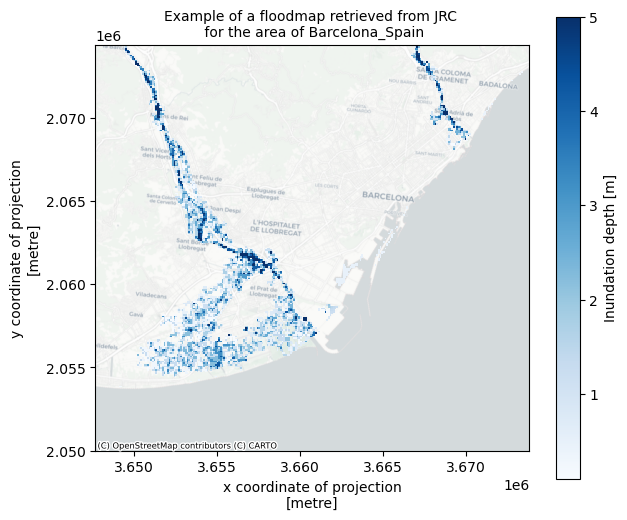

In [12]:
# make a plot of the first map in the dataset
fig, ax = plt.subplots(figsize=(7, 6))
bs=floodmaps['500'].plot(ax=ax,cmap='Blues',add_colorbar=False,vmax=5)
ctx.add_basemap(ax=ax,crs=floodmaps.rio.crs,source=ctx.providers.CartoDB.Positron, attribution_size=6)
plt.title(f'Example of a floodmap retrieved from JRC \n for the area of {areaname}',fontsize=10);
fig.colorbar(bs, ax=ax, orientation="vertical", label='Inundation depth [m]');

Based on the hazard map extent we will define the coordinates of the area of interest.

In [17]:
bbox = [np.min(floodmaps.x.values),np.min(floodmaps.y.values),np.max(floodmaps.x.values),np.max(floodmaps.y.values)]
bbox

[3647750.0, 2050050.0, 3673750.0, 2074350.0]

### Impact of climate change on river discharges and estimated flood hazard
We will use coarse-resolution dataset from Aqueduct Floods to assess the impact of climate change on the projected extreme river flooding. These flood maps were already pre-processed in the hazard assessment workflow (see *Hazard_assessment_FLOOD_RIVER.ipynb* for more details). If you have not yet ran the Hazard assessment script fully, you can do that now to retrieve the flood maps for climate scenarios.

In [63]:
data_dir_aqueduct = os.path.join(hazard_data_dir,'aqueduct_floods')
return_period=250

In [68]:
aq_floodmap_base = xr.open_dataset(os.path.join(data_dir_aqueduct,f'inunriver_historical_000000000WATCH_1980_rp{return_period:05}_{areaname}.nc'))
aq_floodmaps = xr.open_dataset(os.path.join(data_dir_aqueduct,f'inunriver_AllScenarios_AllModels_AllYears_rp{return_period:05}_{areaname}.nc'))

In [66]:
# define discrete colormaps
cmap_flood = plt.get_cmap('Blues', 10) 
cmap_diff = plt.get_cmap('PuOr', 16) 

In [71]:
# choose scenario to visualize
scenario = 'rcp8p5' # 'rcp8p5' or 'rcp4p5'

In [84]:
aq_floodmaps['year'].values.tolist()

[2030, 2050, 2080]

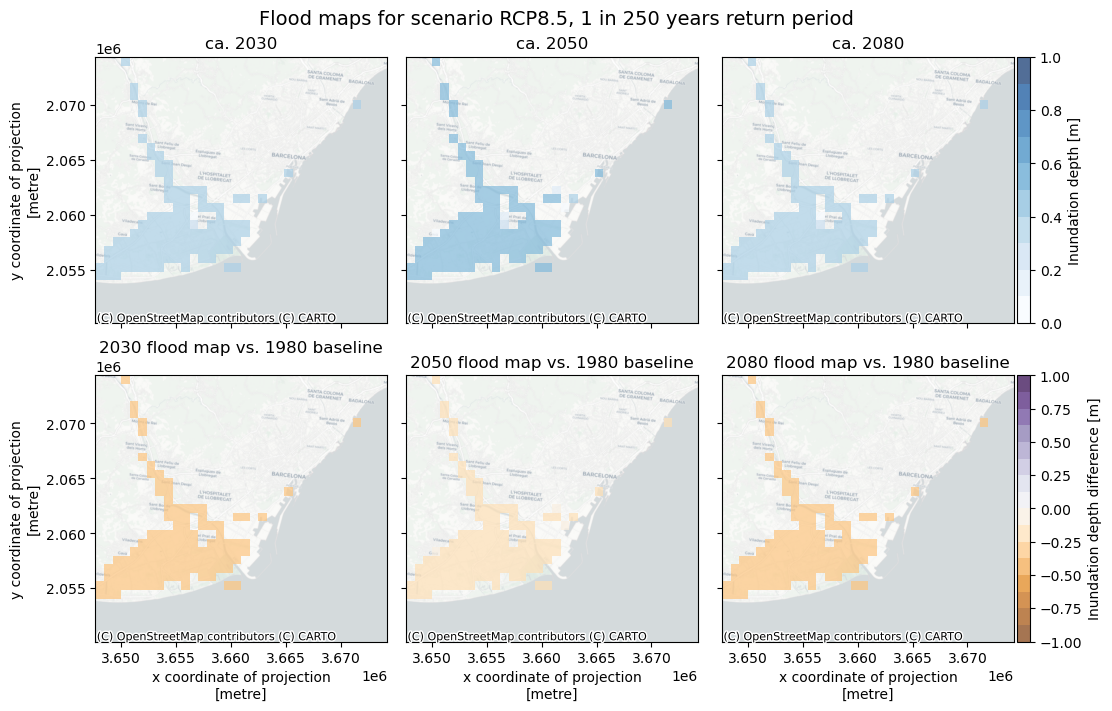

In [87]:
# make plot

# open dataset containing flood maps for all years and models in this scenario
lims = [0,np.ceil(np.nanmax(aq_floodmaps['inun'].isel(year=-1,scenario=-1).values))]
lims_diff = [-1, 1]

# make figure
fig, axs = plt.subplots(figsize=(11, 7),nrows=2,ncols=3,sharex=True,sharey=True, constrained_layout=True)
fig.suptitle(f'Flood maps for scenario {scenario.upper().replace("P5",".5")}, 1 in {return_period} years return period',fontsize=14);

years_all = aq_floodmaps['year'].values.tolist()

for ii,year in enumerate(years_all):
    # plot inundation depth for the given scenario and year (mean of all models)
    if ii == len(years_all)-1:
        aq_floodmaps['inun'].sel(year=year,scenario=scenario).plot(ax=axs[0,ii],alpha=0.7, cmap=cmap_flood,vmin=lims[0],vmax=lims[1],cbar_kwargs={'label': "Inundation depth [m]",'pad':0.01,'aspect':20})
    else:
        aq_floodmaps['inun'].sel(year=year,scenario=scenario).plot(ax=axs[0,ii],alpha=0.7, cmap=cmap_flood,vmin=lims[0],vmax=lims[1],add_colorbar=False)
    ctx.add_basemap(axs[0,ii], crs=aq_floodmaps.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)
    axs[0,ii].set_title(f'ca. {year}',fontsize=12);
    
    # Plot difference against baseline scenario
    aq_floodmaps_diff = aq_floodmaps['inun'].sel(year=year,scenario=scenario) - aq_floodmap_base['inun']
    if ii == len(years_all)-1:
        aq_floodmaps_diff.plot(ax=axs[1,ii], cmap=cmap_diff,alpha=0.7, vmin=lims_diff[0],vmax=lims_diff[1], cbar_kwargs={'label': "Inundation depth difference [m]",'pad':0.01,'aspect':20})
    else:
        aq_floodmaps_diff.plot(ax=axs[1,ii], cmap=cmap_diff,alpha=0.7, vmin=lims_diff[0],vmax=lims_diff[1],add_colorbar=False)
    ctx.add_basemap(axs[1,ii], crs=aq_floodmaps.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)
    axs[1,ii].set_title(f'{year} flood map vs. 1980 baseline',fontsize=12);

    if ii>0:
        axs[0,ii].set(ylabel=None)
        axs[1,ii].set(ylabel=None)
    axs[0,ii].xaxis.label.set_visible(False)

The figure above provides a comparison between the projected inundation depths in the future under climate scenarios and the baseline maps (1980 climate). Where negative values are shown in the comparison, it means that the inundation depth is expected to decrease, possibly due to reduced river flow. In this case we can assume that the further analysis using the JRC floodmaps for the present climate are representative (or concervatively-representative) of the future risks as well.

In case a significant increase in inundation depth is seen in the comparison maps above, it is expected that the river flood hazard at this location will increase with climate change. While not quantifying the future risk directly in this workflow, we need to keep this in mind when interpreting the results.

## Exposure - land-use data

Next we need the information on land use.  We will download the land use dataset from the JRC data portal, a copy of the dataset will be saved locally for ease of access. In this notebook we use the land use maps with 100 m resolution. The land use maps can also be downloaded manually from the [JRC portal](http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/LUISA/EUROPE/Basemaps/2018/VER2021-03-24/).

In [18]:
landuse_res = 100 # choose resolution (options: 50 or 100 m)
luisa_filename = f'LUISA_basemap_020321_{landuse_res}m.tif'

# Check if land use dataset has not yet been downloaded
if  not os.path.isfile(os.path.join(data_general_dir,luisa_filename)):
    # , define the URL for the LUISA basemap and download it
    url = f'http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/LUISA/EUROPE/Basemaps/2018/VER2021-03-24/{luisa_filename}'
    pooch.retrieve(
        url=url,
        known_hash=None,  # Hash value is not provided
        path=data_general_dir,    # Save the file to the specified data directory
        fname=luisa_filename  # Save the file with a specific name
    )
else:
    print(f'Land use dataset already downloaded at {data_general_dir}/{luisa_filename}')

Land use dataset already downloaded at FLOOD_RIVER_risk\general_data/LUISA_basemap_020321_100m.tif


The Land use data is saved into the local data directory. The data shows on a 100 by 100 meter resolution what the land use is for Europe in 2018. The land use encompasses various types of urban areas, natural land, agricultural fields, infrastructure and waterbodies. This will be used as the first exposure layer in the risk assessment.

In [19]:
# Define the filename for the land use map based on the specified data directory
filename_land_use = f'{data_general_dir}/{luisa_filename}'

# Open the land use map raster 
land_use = rxr.open_rasterio(filename_land_use)

# Display the opened land use map
land_use

<xarray.DataArray (band: 1, y: 46000, x: 65000)>
[2990000000 values with dtype=int32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 9e+05 9.002e+05 9.002e+05 ... 7.4e+06 7.4e+06
  * y            (y) float64 5.5e+06 5.5e+06 5.5e+06 ... 9.002e+05 9e+05
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

The land use dataset needs to be clipped to the area of interest. For visualization purposes, each land use type is then assigned a color. Land use plot shows us the variation in land use over the area of interest.

In [20]:
# Set the coordinate reference system (CRS) for the land use map to EPSG:3035
land_use.rio.write_crs(3035, inplace=True)

# Clip the land use map to the specified bounding box and CRS
land_use_local = land_use.rio.clip_box(*bbox, crs=floodmaps.rio.crs)

# File to store the local land use map
landuse_map = os.path.join(data_dir, f'land_use_{areaname}.tif') 

# Save the clipped land use map
with rasterio.open(
    landuse_map,
    'w',
    driver='GTiff',
    height=land_use_local.shape[1],
    width=land_use_local.shape[2],
    count=1,
    dtype=str(land_use_local.dtype),
    crs=land_use_local.rio.crs,
    transform=land_use_local.rio.transform()
) as dst:
    # Write the data array values to the rasterio dataset
    dst.write(land_use_local.values)

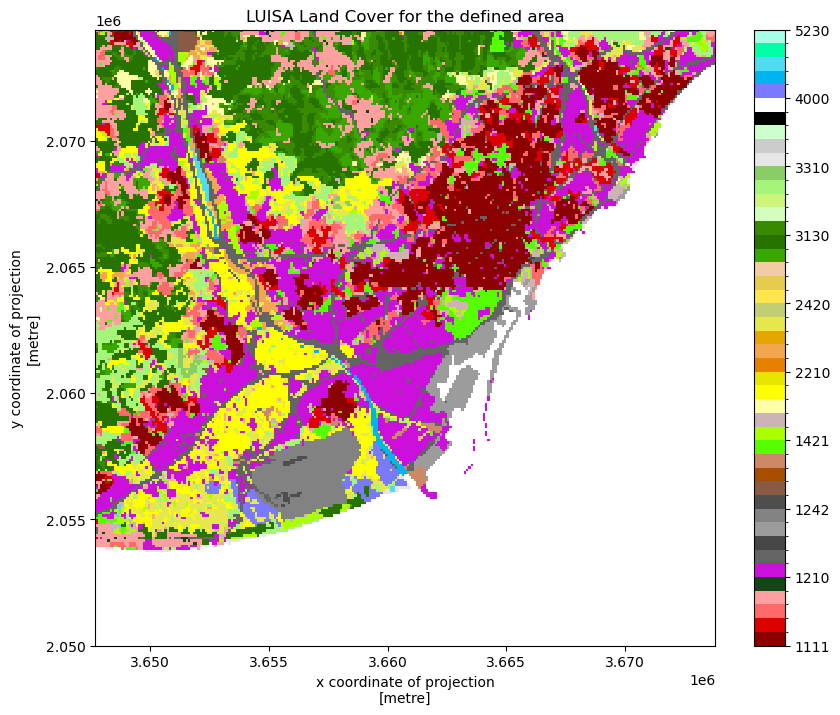

In [21]:
# Plotting

# Define values and colors for different land use classes
LUISA_values = [1111, 1121, 1122, 1123, 1130,
                1210, 1221, 1222, 1230, 1241,
                1242, 1310, 1320, 1330, 1410,
                1421, 1422, 2110, 2120, 2130,
                2210, 2220, 2230, 2310, 2410,
                2420, 2430, 2440, 3110, 3120,
                3130, 3210, 3220, 3230, 3240,
                3310, 3320, 3330, 3340, 3350,
                4000, 5110, 5120, 5210, 5220,
                5230]

LUISA_colors = ["#8c0000", "#dc0000", "#ff6969", "#ffa0a0", "#14451a",
                "#cc10dc", "#646464", "#464646", "#9c9c9c", "#828282",
                "#4e4e4e", "#895a44", "#a64d00", "#cd8966", "#55ff00",
                "#aaff00", "#ccb4b4", "#ffffa8", "#ffff00", "#e6e600",
                "#e68000", "#f2a64d", "#e6a600", "#e6e64d", "#c3cd73",
                "#ffe64d", "#e6cc4d", "#f2cca6", "#38a800", "#267300",
                "#388a00", "#d3ffbe", "#cdf57a", "#a5f57a", "#89cd66",
                "#e6e6e6", "#cccccc", "#ccffcc", "#000000", "#ffffff",
                "#7a7aff", "#00b4f0", "#50dcf0", "#00ffa6", "#a6ffe6",
                "#e6f2ff"]

# Plot the land use map using custom levels and colors
land_use_local.plot(levels=LUISA_values, colors=LUISA_colors, figsize=(10, 8))

# Set the title for the plot
plt.title('LUISA Land Cover for the defined area');

## Vulnerability - damage curves for land use

We will use damage curve files from the JRC that are already available in the GitHub repository folder.

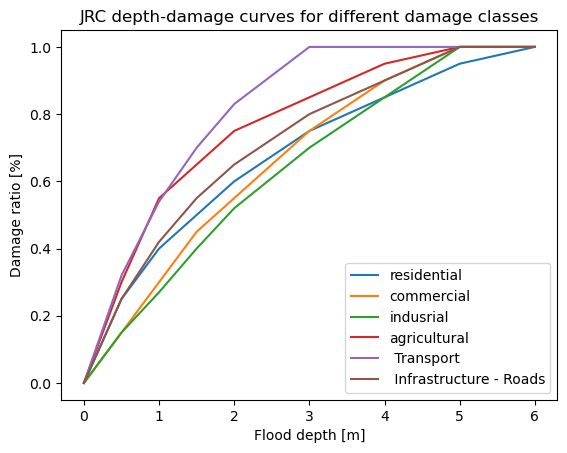

In [22]:
# Import damage curves of the JRC from a CSV file into a pandas DataFrame
JRC_curves = pd.read_csv('JRC_damage_curves.csv', index_col=0)

# Plot the JRC depth-damage curves
JRC_curves.plot()

# Set the title and labels for the plot
plt.title('JRC depth-damage curves for different damage classes');
plt.xlabel('Flood depth [m]');
plt.ylabel('Damage ratio [%]');

# Processing data
The maps of flooding, land use and infrastructure can be combined to assess multipe types of risk from river flooding in a region. This way we can estimate the exposure of population, infrastructure and economic assets to river floods. In this section we will align the resolutions of the datasets, prepare vulnerability curvers and calculate the damage maps.

## Combining datasets with different resolution
Before we can calculate risk indices, we will prepare the data by aligning the spatial resolution of the datasets and by calculating the vulnerability curves for economic damages based on specified information.  

The flood and land use datasets have different spatial resolutions. Flood extent maps are at a resolution of 30-75 m (resolution varies with latitude), while land use data is at a constant 100 m (or 50 m) resolution. We can bring them to the same resolution. It is preferable to interpolate the flood map onto the land use grid (and not the other way around), because land use is defined in terms of discrete values and on a more convenient regularly spaced grid. We will interpolate the flood data onto the land use map grid in order to be able to calculate the damages.   

In [23]:
# Reproject the flood map to match the resolution and extent of the land use map
rps = list(floodmaps.data_vars) # available return periods

for rp in rps:
    ori_map = floodmaps[rp]
    new_map = ori_map.rio.reproject_match(land_use_local, resampling=Resampling.bilinear); del ori_map
    ds = new_map.to_dataset(); del new_map

    if (rp==rps[0]):
        floodmaps_resampled = ds
    else:
        floodmaps_resampled = floodmaps_resampled.merge(ds)

In [24]:
# check the new resolution of the floodmap (should be equivalent to the land use map resolution)
floodmaps_resampled.rio.resolution()

(100.0, -100.0)

We will save the resampled flood maps as raster files locally, so that we can more easily use them as input to calculate economic damages.

In [25]:
# Create GeoTIFF files for the resampled flood maps
tif_dir = os.path.join(data_dir,f'floodmaps_resampled')
if not os.path.isdir(tif_dir): os.makedirs(tif_dir)

In [26]:
floodmaps_resampled['500'][0]

<xarray.DataArray '500' (y: 244, x: 261)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    band         int32 1
    spatial_ref  int32 0
  * x            (x) float64 3.648e+06 3.648e+06 ... 3.674e+06 3.674e+06
  * y            (y) float64 2.074e+06 2.074e+06 2.074e+06 ... 2.05e+06 2.05e+06
Attributes:
    AREA_OR_POINT:           Area
    DataType:                Generic
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  8.857045422371877
    STATISTICS_MAXIMUM:      276.49700927734
    STATISTICS_MEAN:         2.3875402056979
    STATISTICS_MINIMUM:      0.10000000149012
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       2.976078866961

In [27]:
for rp in rps:
    data_tif = floodmaps_resampled[rp][0]
    with rasterio.open(
        f'{tif_dir}/floodmap_resampled_{areaname}_rp{rp}.tif',  
        'w',
        driver='GTiff',
        height=data_tif.shape[0],
        width=data_tif.shape[1],
        count=1,                    
        dtype=str(data_tif.dtype),
        crs=data_tif.rio.crs,
        transform=data_tif.rio.transform(),
    ) as dst:
        # Write the data array values to the rasterio dataset
        dst.write(data_tif.values,indexes=1)

## Linking land use types to economic damages

In order to assess the potential damage done by the flooding in a given scenario, we also need to assign a monetary value to the land use categories. We define this as the potential loss in €/m². The calculation of economic value for different land use types is made with help of an  accompanying template (**LUISA_damage_info_curves.xlsx**).

In [33]:
damage_info_file = f'LUISA_damage_info_curves_{areaname}.xlsx'
shutil.copyfile('LUISA_damage_info_curves_template.xlsx',os.path.join(data_dir,damage_info_file))

'FLOOD_RIVER_risk\\data_Barcelona_Spain\\LUISA_damage_info_curves_Barcelona_Spain.xlsx'

**Important: Please go to the newly created file and adjust the information on the GDP per capita in the first line of the Excel sheet.**

In [34]:
# Read damage curve information from an Excel file into a pandas DataFrame
LUISA_info_damage_curve = pd.read_excel('LUISA_damage_info_curves_template.xlsx', index_col=0)

# Extract the 'total €/m²' column to get the maximum damage for reconstruction
maxdam = pd.DataFrame(LUISA_info_damage_curve['total €/m²'])

# Save the maximum damage values to a CSV file
maxdam_path = os.path.join(data_dir, f'maxdam_luisa.csv')
maxdam.to_csv(maxdam_path)

# Display the first 10 rows of the resulting DataFrame to view the result
maxdam.head(10)

,total €/m²
Land use code,
1111,600.269784
1121,414.499401
1122,245.022999
1123,69.919184
1130,0.000000
1210,405.238393
1221,40.417363
1222,565.843080
1230,242.504177


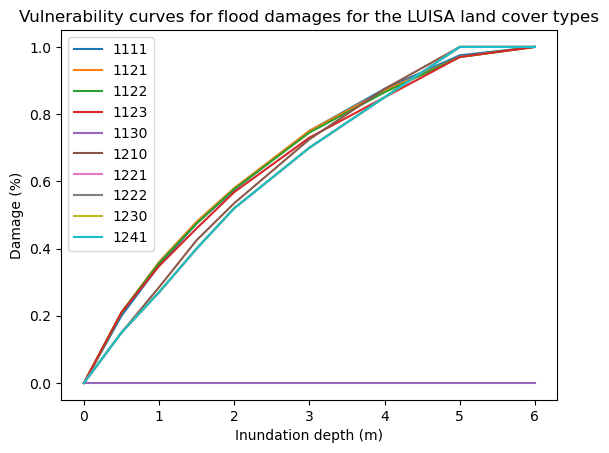

In [35]:
# Create a new DataFrame for damage_curves_luisa by copying JRC_curves
damage_curves_luisa = JRC_curves.copy()

# Drop all columns in the new DataFrame
damage_curves_luisa.drop(damage_curves_luisa.columns, axis=1, inplace=True)

# Define building types for consideration
building_types = ['residential', 'commercial', 'industrial']

# For each land use class in maxdamage, create a new damage curve
for landuse in maxdam.index:
    # Find the ratio of building types in the class
    ratio = LUISA_info_damage_curve.loc[landuse, building_types].values

    # Create a new curve based on the ratios and JRC_curves
    damage_curves_luisa[landuse] = ratio[0] * JRC_curves.iloc[:, 0] + \
                                   ratio[1] * JRC_curves.iloc[:, 1] + \
                                   ratio[2] * JRC_curves.iloc[:, 2]

# Save the resulting damage curves to a CSV file
curve_path = os.path.join(data_dir, 'curves.csv')
damage_curves_luisa.to_csv(curve_path)    

# Plot the vulnerability curves for the first 10 land cover types
damage_curves_luisa.iloc[:, 0:10].plot()
plt.title('Vulnerability curves for flood damages for the LUISA land cover types');
plt.ylabel('Damage (%)');
plt.xlabel('Inundation depth (m)');


## Calculate potential economic damage to infrastructure using DamageScanner

Now that we have all pieces of the puzzle in place, we can perform the risk calculation. For this we are using the [DamageScanner](https://damagescanner.readthedocs.io/en/latest/index.html) python library which allows for an easy damage calculation. 

The DamageScanner takes the following data:
- The clipped and resampled flood map 
- The clipped land use map
- The vulnerability curves per land use category
- A table of maximum damages per land use category 

We can perform the damage calculations for all scenarios and return periods now:

In [36]:
for rp in rps:
    inun_map = os.path.join(tif_dir, f'floodmap_resampled_{areaname}_rp{rp}.tif') # Define file path for the flood map input 

    # Do the damage calculation and save the results
    loss_df = RasterScanner(landuse_map,
                            inun_map,
                            curve_path,
                            maxdam_path, 
                            save = True, 
                            nan_value = None, 
                            scenario_name= '{}/flood_{}_rp{}'.format(results_dir,areaname,rp),
                            dtype = np.int64)
    loss_df_renamed = loss_df[0].rename(columns={"damages": "rp{}".format(rp)})
    
    if (rp==rps[0]):
        loss_df_all = loss_df_renamed
    else:
        loss_df_all = pd.concat([loss_df_all, loss_df_renamed], axis=1)

Now the dataframe *loss_df_all* contains the results of damage calculations for all scenarios and return periods. We will format this dataframe for easier interpretation:

In [37]:
# Obtain the LUISA legend and add it to the table of damages
LUISA_legend = LUISA_info_damage_curve['Description']

# Convert the damages to million euros
loss_df_all_mln = loss_df_all / 10**6

# Combine loss_df with LUISA_legend
category_damage = pd.concat([LUISA_legend, (loss_df_all_mln)], axis=1)

# Sort the values by damage in descending order (based on the column with the highest damages)
category_damage.sort_values(by='rp500', ascending=False, inplace=True)

# Display the resulting DataFrame (top 10 rows)
category_damage.head(10)

,Description,rp010,rp020,rp050,rp100,rp200,rp500
1241,Airport areas,323.367098,508.561086,816.722621,947.972076,1022.351758,1115.876335
1210,Industrial or commercial units,413.495631,479.685347,540.248628,577.567844,627.669635,692.920169
2120,Permanently irrigated land,157.901374,176.320777,196.787318,207.938294,217.701513,232.813971
2310,Pastures,69.259803,87.681442,111.242555,124.279228,135.378402,150.307853
1221,Road and rail networks and associated land,50.149823,60.994541,67.714558,71.620383,75.347110,80.566520
1330,Construction sites,45.891546,52.357559,57.809431,60.742278,63.224605,66.299314
4000,Wetlands,14.794995,30.757369,43.399548,47.862028,51.419575,55.471638
2220,Fruit trees and berry plantations,31.403429,42.767350,46.854671,49.793838,52.035611,54.530279
3230,Sclerophyllous vegetation,21.186971,29.104251,33.481290,35.445697,37.185767,40.200647
1421,Sport and leisure green,15.375771,20.975113,24.979845,28.303910,30.520497,33.757075


## Plot the results

Now we can plot the damages to get a spatial view of what places can potentially be most affected economically. 
To do this, first the damage maps for all scenarios will be loaded into memory and formatted:

In [38]:
# load all damage maps and merge into one dataset
for rp in rps:
    damagemap = rxr.open_rasterio('{}/flood_{}_rp{}_damagemap.tif'.format(results_dir,areaname,rp)).squeeze()
    damagemap = damagemap.where(damagemap > 0)/10**6
    damagemap.load()
    
    # prepare for merging
    damagemap.name = 'damages'
    damagemap = damagemap.assign_coords(return_period=rp); 
    ds = damagemap.to_dataset(); del damagemap
    ds = ds.expand_dims(dim={'return_period':1})

    # merge
    if (rp==rps[0]):
        damagemap_all = ds
    else:
        damagemap_all = damagemap_all.merge(ds)
damagemap_all.x.attrs['long_name'] = 'X coordinate'; damagemap_all.x.attrs['units'] = 'm'
damagemap_all.y.attrs['long_name'] = 'Y coordinate'; damagemap_all.y.attrs['units'] = 'm'
damagemap_all.load()

<xarray.Dataset>
Dimensions:        (x: 261, y: 244, return_period: 6)
Coordinates:
  * x              (x) float64 3.648e+06 3.648e+06 ... 3.674e+06 3.674e+06
  * y              (y) float64 2.074e+06 2.074e+06 ... 2.05e+06 2.05e+06
  * return_period  (return_period) <U3 '010' '020' '050' '100' '200' '500'
    band           int32 1
    spatial_ref    int32 0
Data variables:
    damages        (return_period, y, x) float64 nan nan nan nan ... nan nan nan

Now we can plot the damage maps to compare:

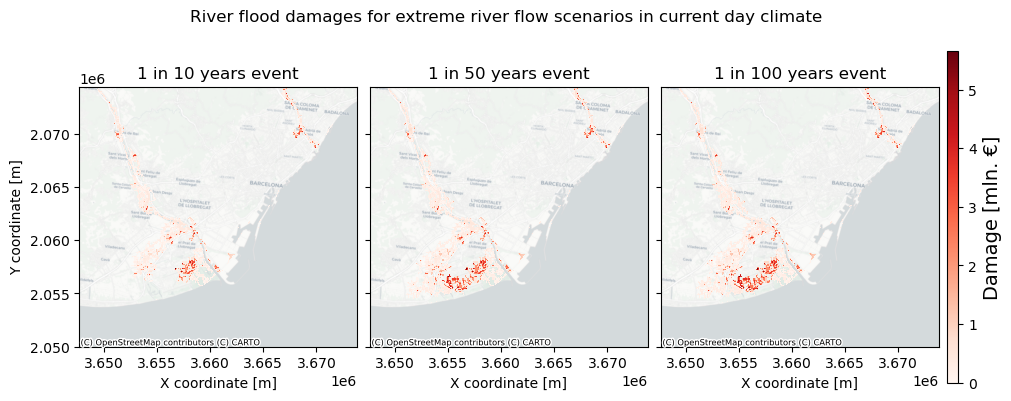

In [47]:
# select return periods to plot
rps_sel = [10,50,100]

# Plot damage maps for different scenarios and return periods
fig,axs = plt.subplots(figsize=(10, 4),nrows=1,ncols=len(rps_sel),constrained_layout=True,sharex=True,sharey=True)

# define limits for the damage axis based on the map with highest damages
vrange = [0,np.nanmax(damagemap_all.sel(return_period='500')['damages'].values)]

for rr,rp in enumerate(rps_sel):
    
    # Plot the damagemap with a color map representing damages and a color bar
    bs=damagemap_all.sel(return_period=f'{rps_sel[rr]:03}')['damages'].plot(ax=axs[rr], vmin=vrange[0], vmax=vrange[1], cmap='Reds', add_colorbar=False)
    
    ctx.add_basemap(axs[rr],crs=damagemap_all.rio.crs.to_string(),source=ctx.providers.CartoDB.Positron, attribution_size=6) # add basemap
    axs[rr].set_title(f'1 in {rps_sel[rr]} years event',fontsize=12)
    if rr>0:
        axs[rr].yaxis.label.set_visible(False)
   
fig.colorbar(bs,ax=axs[:],orientation="vertical",pad=0.01,shrink=0.9,aspect=30).set_label(label=f'Damage [mln. €]',size=14)  
fig.suptitle('River flood damages for extreme river flow scenarios in current day climate',fontsize=12);

fileout = os.path.join(plot_dir,'Result_map_{}_damages_overview.png'.format(areaname))
fig.savefig(fileout) 

To get a better indication of why certain areas are damaged more than others, we can also plot the floodmap and land use maps in one figure for a given return period.

In [48]:
# Select year and return period to plot:
year = 2050
rp = 500

# load damage map
damagemap = rxr.open_rasterio('{}/flood_{}_rp{}_damagemap.tif'.format(results_dir,areaname,rp))
damagemap = damagemap.where(damagemap > 0)/10**6

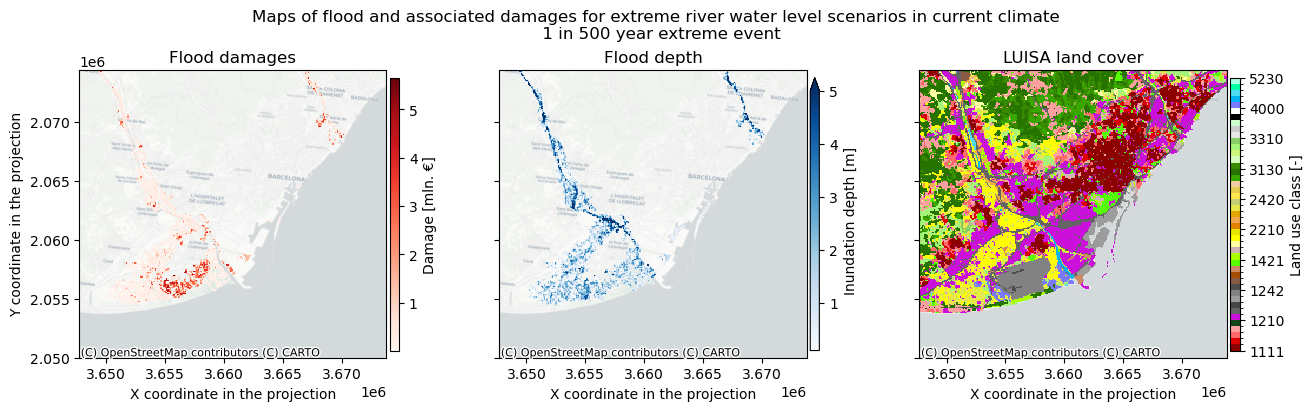

In [57]:
fig, ([ax1, ax2, ax3]) = plt.subplots(figsize=(13, 4),nrows=1,ncols=3,sharex=True,sharey=True,layout='constrained')

# Plot flood damages on the first plot
damagemap.plot(ax=ax1, cmap='Reds', cbar_kwargs={'label': "Damage [mln. €]",'pad':0.01,'shrink':0.95,'aspect':30})
ax1.set_title(f'Flood damages')
ax1.set_xlabel('X coordinate in the projection'); ax1.set_ylabel('Y coordinate in the projection')

# Plot inundation depth on the second plot
max_inun=5 # set max depth to include in the colorbar
floodmaps_resampled['500'].plot(ax=ax2, cmap='Blues', vmax=max_inun, cbar_kwargs={'label': "Inundation depth [m]",'pad':0.01,'shrink':0.95,'aspect':30})
ax2.set_title(f'Flood depth')
ax2.set_xlabel('X coordinate in the projection'); ax2.set_ylabel('Y coordinate in the projection')
ax2.yaxis.label.set_visible(False)

# Plot land use on the third plot with custom colors
land_use_local.plot(ax=ax3, levels=LUISA_values, colors=LUISA_colors, cbar_kwargs={'label': "Land use class [-]",'pad':0.01,'shrink':0.95,'aspect':30})
ax3.set_title('LUISA land cover')
ax3.set_xlabel('X coordinate in the projection'); ax3.set_ylabel('Y coordinate in the projection')
ax3.yaxis.label.set_visible(False)

plt.suptitle(f'Maps of flood and associated damages for extreme river water level scenarios in current climate \n 1 in {rp} year extreme event',fontsize=12)

# Add a map background to each plot using Contextily
ctx.add_basemap(ax1, crs=damagemap.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax2, crs=floodmaps_resampled.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax3, crs=land_use_local.rio.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Display the plot
plt.show()

fileout = os.path.join(plot_dir,'Result_map_{}_rp{}.png'.format(areaname,rp))
fig.savefig(fileout) 

Here we see both the the potential flood depths and the associated economic damages. This overview helps to see which areas carry the most economic risk under the flooding scenarios.

Make sure to check the results and try to explain why high damages do or do not occur in case of high innundation. 

## Conclusions
Now that you were able to calculate damage maps based on flood maps and view the results, it is time to revisit the information about the accuracy and applicability of European flood maps to local contexts. 

Consider the following questions:  
 - How accurate do you think this result is for your local context? Are there geographical and/or infrastructural factors that make this result less accurate?
 - What information are you missing that could make this assessment more accurate?
 - What can you already learn from these maps of river flood potential and maps of potential damages?
 - How do you expect the projected damages due to river flooding to change under climate change in this region?

:::{important}

In this risk workflow we learned:
 - How to access use European-scale land use datasets.
 - How to assign each land use with a vulnerability curve and maximum damage.
 - Combining the flood (hazard), land use (exposure), and the vulnerability curves (vulnerability) to obtain an economic damage estimate.
 - Understand where damage comes from and how exposure and vulnerability are an important determinant of risk.
:::


## Contributors

Applied research institute Deltares (The Netherlands). 

Authors of the workflow:   
Natalia Aleksandrova  
Ted Buskop
